In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree

plt.style.use('seaborn-v0_8')
%matplotlib inline

In [6]:
water_data = pd.read_csv('data/water_potability.csv')

water_data.head(2)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.71608,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0


In [7]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [8]:
null_feat_list = [x[0] for x in \
        list(water_data.isnull().mean().items()) \
        if x[1] != 0
        ]

for feat in null_feat_list:
    
    water_data[feat] = water_data[feat].fillna(
        water_data.groupby('Potability')[feat].transform('median')
        )

In [9]:
display(water_data.isnull().mean() * 100)


ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

In [10]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

### hold-out

In [11]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5, 
    random_state=42
)

model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_valid_predict = model.predict(X_valid)

print(f'Train hold-out score = {metrics.accuracy_score(y_train_predict, y_train):.2f}')
print(f'Test hold-out score = {metrics.accuracy_score(y_valid_predict, y_valid):.2f}')


Train hold-out score = 0.82
Test hold-out score = 0.77


**Для разбивки на три части, надо будет применить метод train_test_split дважды. Сначала разбить на тренировочную и валидационную, а затем валидационную на валидационную и тестовую.**

### K-FOLD (кросс-валидация)

In [15]:
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5, 
    random_state=42
)

kf = model_selection.KFold(n_splits=5)

train_metrics = []
valid_metrics = []

for train_index, valid_index in kf.split(X, y):
    
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    
    model.fit(X_train, y_train)
    
    y_train_predict = model.predict(X_train)
    y_valid_predict = model.predict(X_valid)
    
    train_metrics.append(round(metrics.accuracy_score(y_train_predict, y_train), 5))
    valid_metrics.append(round(metrics.accuracy_score(y_valid_predict, y_valid), 5))
    
print(train_metrics)
print(valid_metrics)

[0.80344, 0.81686, 0.80275, 0.82678, 0.81572]
[0.79573, 0.70534, 0.73588, 0.72824, 0.73282]


In [17]:
print(f'Mean train accuracy score is: {np.mean(train_metrics):.2f}')
print(f'Mean valid accuracy score is: {np.mean(valid_metrics):.2f}')

Mean train accuracy score is: 0.81
Mean valid accuracy score is: 0.74


**Функция кросс-валидации**

In [18]:
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5, 
    random_state=42
)

kf = model_selection.KFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model,
    X=X, 
    y = y, 
    cv = kf,
    scoring='accuracy',
    return_train_score=True
)

display(cv_metrics)

{'fit_time': array([0.02857614, 0.02646184, 0.01990438, 0.02593112, 0.01735735]),
 'score_time': array([0.        , 0.00200057, 0.        , 0.00199485, 0.        ]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [19]:
print(f'Mean train accuracy score is: {np.mean(cv_metrics['train_score']):.2f}')
print(f'Mean valid accuracy score is: {np.mean(cv_metrics['test_score']):.2f}')

Mean train accuracy score is: 0.81
Mean valid accuracy score is: 0.74


### LEAVE-ONE-OUT (поэлементная кросс-валидация)

In [20]:
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5, 
    random_state=42
)

loo = model_selection.LeaveOneOut()

cv_metrics_loo = model_selection.cross_validate(
    estimator=model,
    X = X.iloc[:500], 
    y = y.iloc[:500],
    cv = loo,
    scoring='accuracy',
    return_train_score=True
)

print(f'Mean train accuracy score is: {np.mean(cv_metrics_loo['train_score']):.2f}')
print(f'Mean valid accuracy score is: {np.mean(cv_metrics_loo['test_score']):.2f}')

Mean train accuracy score is: 0.95
Mean valid accuracy score is: 0.90


### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

In [21]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.620229
1    0.379771
Name: proportion, dtype: float64
Valid:
Potability
0    0.568598
1    0.431402
Name: proportion, dtype: float64


In [22]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.609924
1    0.390076
Name: proportion, dtype: float64
Valid:
Potability
0    0.609756
1    0.390244
Name: proportion, dtype: float64


**вместо KFold используется кросс-валидатор StratifiedKFold.**

In [23]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------


**Задание 3.3**

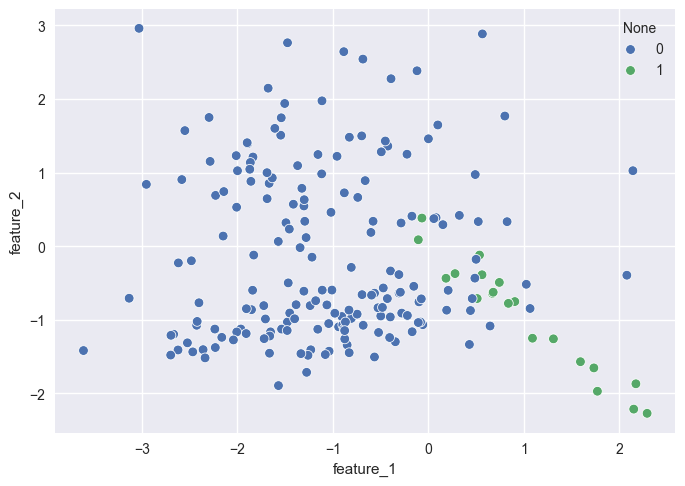

In [ ]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

# X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# 

<Axes: xlabel='feature_1', ylabel='feature_2'>

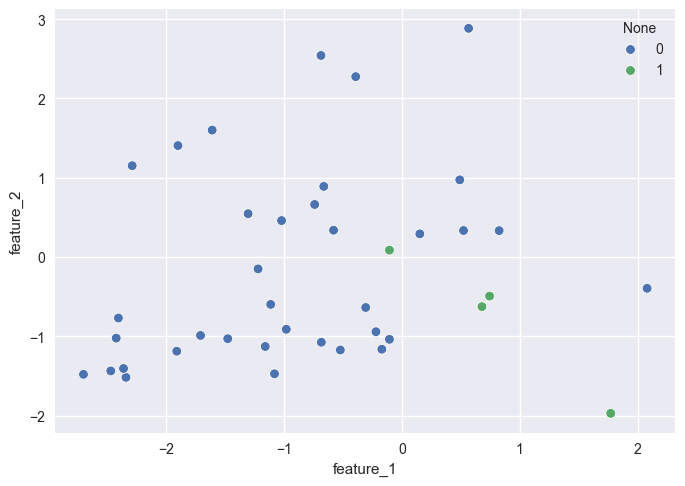

In [44]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y_valid)

# X_valid

In [40]:
model_lr = linear_model.LogisticRegression(random_state=42)

model_lr.fit(X_train, y_train)

y_valid_predict = model_lr.predict(X_valid)

print(metrics.classification_report(y_valid_predict, y_valid))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95        38
           1       0.25      0.50      0.33         2

    accuracy                           0.90        40
   macro avg       0.61      0.71      0.64        40
weighted avg       0.94      0.90      0.92        40



C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


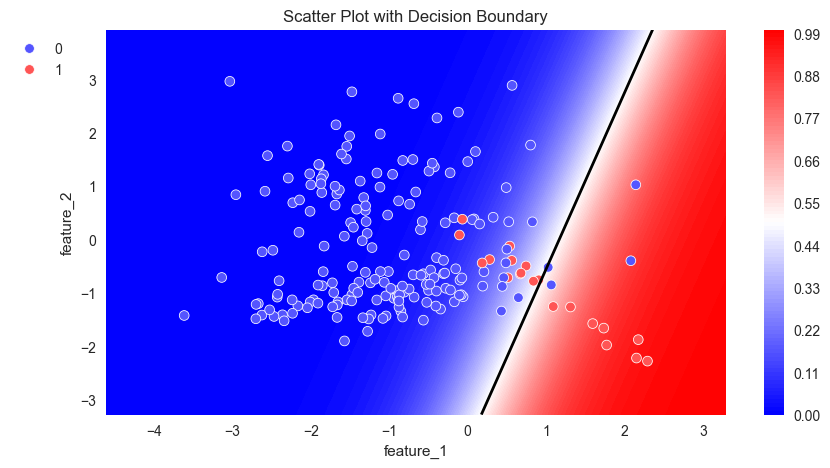

In [41]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
    
plot_probabilities_2d(X, y, model_lr)

### ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

**ВЗВЕШИВАНИЕ ОБЪЕКТОВ**   **SMOTE**

In [48]:
water_df = pd.read_csv('data/water_potability.csv')

In [49]:
water_df.head(2)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.71608,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0


In [50]:
X = water_df.drop('Potability', axis=1)
y = water_df['Potability']

In [51]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [53]:
model_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)

model_tr.fit(X_train, y_train)

y_train_predict_tr = model_tr.predict(X_train)
y_valid_predict_tr = model_tr.predict(X_valid)

print(metrics.classification_report(y_train, y_train_predict_tr))
print(metrics.classification_report(y_valid, y_valid_predict_tr))

              precision    recall  f1-score   support

           0       0.80      0.52      0.63      1598
           1       0.51      0.79      0.62      1022

    accuracy                           0.63      2620
   macro avg       0.65      0.66      0.63      2620
weighted avg       0.69      0.63      0.63      2620

              precision    recall  f1-score   support

           0       0.70      0.49      0.58       400
           1       0.46      0.67      0.55       256

    accuracy                           0.56       656
   macro avg       0.58      0.58      0.56       656
weighted avg       0.61      0.56      0.57       656



In [56]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)


X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


model_lr_37 = linear_model.LogisticRegression(class_weight='balanced', random_state=42)

model_lr_37.fit(X_train, y_train)

y_valid_predict_37 = model_lr_37.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_predict_37))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



**Задание 3.8**

C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


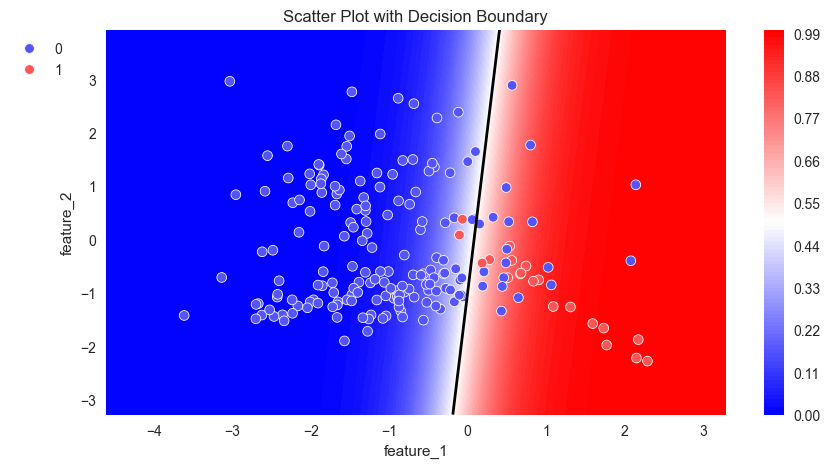

In [57]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
    
plot_probabilities_2d(X, y, model_lr_37)

### ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

In [92]:
water_df_auc = pd.read_csv('data/water_potability.csv')

In [93]:
null_feat_list = [x[0] for x in \
        list(water_df_auc.isnull().mean().items()) \
        if x[1] != 0
        ]

for feat in null_feat_list:
    
    water_df_auc[feat] = water_df_auc[feat].fillna(
        water_df_auc.groupby('Potability')[feat].transform('median')
        )

In [94]:
X = water_df_auc.drop('Potability', axis=1)
y = water_df_auc['Potability']

In [102]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# X_train, y_train, X_valid, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [103]:
model_tr_auc = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

In [104]:
model_tr_auc.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=5,
                       random_state=42)

In [105]:

skf = model_selection.StratifiedKFold(n_splits=5)

y_cv_proba_pred = model_selection.cross_val_predict(model_tr_auc, X_train, y_train, cv=skf, method='predict_proba')

y_cv_proba_pred = y_cv_proba_pred[:, 1]

precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.07142857 0.08333333 0.08695652 0.09859155]
Precision scores: [0.39465649 0.5101626  0.51068159 0.51095262 0.51096379]
Recall scores: [1.         0.97098646 0.97098646 0.97001934 0.96905222]


In [106]:
f1_scores = (2*precision*recall) / (precision + recall)

idx = np.argmax(f1_scores)

print(f'Best F-1 score is {f1_scores[idx]:.2f} with threshold = {thresholds[idx]:.2f}')



Best F-1 score is 0.70 with threshold = 0.34


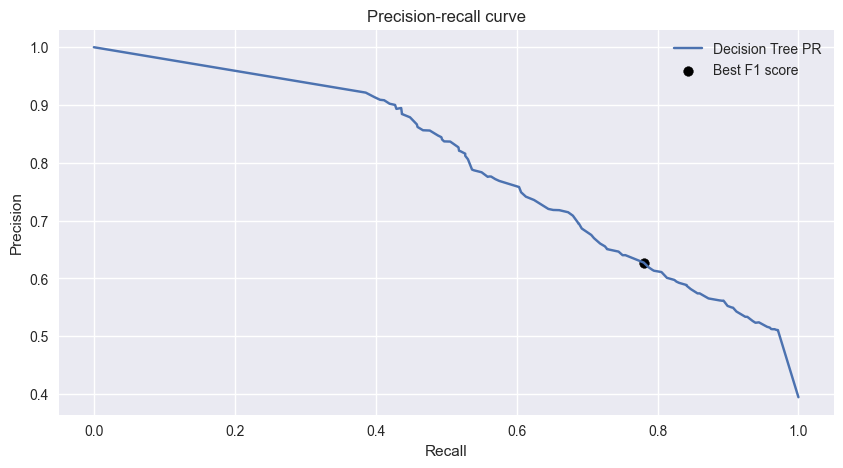

In [107]:
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [117]:
thresholds_opt = 0.34   

y_valid_predict_proba_auc = model_tr_auc.predict_proba(X_valid)[:,1]

In [118]:
y_valid_predict_auc = (y_valid_predict_proba_auc > thresholds_opt).astype('int')


In [120]:
print(metrics.classification_report(y_valid, y_valid_predict_auc))


              precision    recall  f1-score   support

           0       0.88      0.65      0.74       412
           1       0.59      0.84      0.69       244

    accuracy                           0.72       656
   macro avg       0.73      0.74      0.72       656
weighted avg       0.77      0.72      0.72       656



In [121]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.80


### СЭМПЛИРОВАНИЕ

In [ ]:
from imblearn.over_sampling import SMOTE



In [126]:
sm = SMOTE(random_state=2)

X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape)
print('Class balance before oversmpling: \n', y_train.value_counts(), sep = '')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversamoling: \n', y_train_s.value_counts(), sep = '')

Train shape before oversampling: (2620, 9)
Class balance before oversmpling: 
Potability
0    1586
1    1034
Name: count, dtype: int64
----------------------------------------
Train shape after oversampling: (3172, 9)
Class balance after oversamoling: 
Potability
0    1586
1    1586
Name: count, dtype: int64


In [127]:
model_sm = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

model_sm.fit(X_train_s, y_train_s)

y_train_sm_pred = model_sm.predict(X_train)
y_valid_sm_pred = model_sm.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_sm_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       412
           1       0.66      0.68      0.67       244

    accuracy                           0.75       656
   macro avg       0.74      0.74      0.74       656
weighted avg       0.75      0.75      0.75       656



In [129]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
# sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


sm_lr = SMOTE(random_state=42)

X_train_lr_s, y_train_lr_s = sm_lr.fit_resample(X_train, y_train)

model_lr_sm = linear_model.LogisticRegression(random_state=42)

model_lr_sm.fit(X_train_lr_s, y_train_lr_s)

y_train_lr_sm_pred = model_lr_sm.predict(X_train)
y_valid_lr_sm_pred = model_lr_sm.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_lr_sm_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


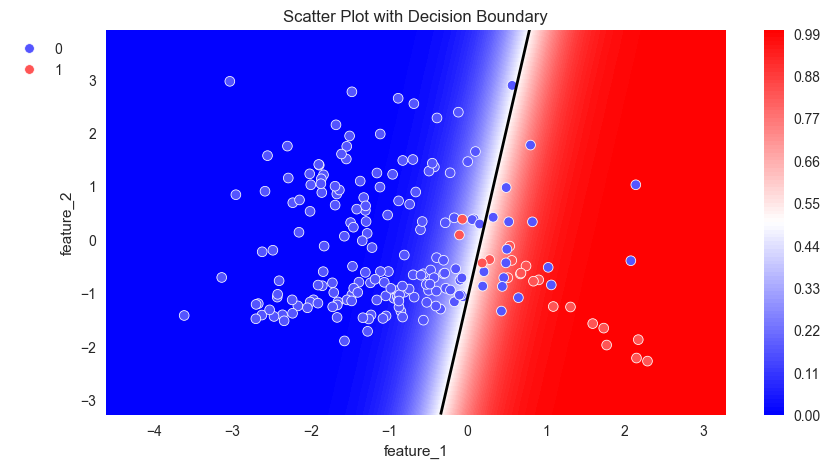

In [130]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
    
plot_probabilities_2d(X, y, model_lr_sm)

## 4. Недообучение и переобучение. Утечка данных

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree

from imblearn.over_sampling import SMOTE
from sklearn import datasets

plt.style.use('seaborn-v0_8')
%matplotlib inline

In [3]:
water_df = pd.read_csv('data/water_potability.csv')
water_df.head(1)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.99097,2.963135,0


**Данные по воде**

In [21]:
X = water_df.drop('Potability', axis=1)
y = water_df['Potability']

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [6]:
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    random_state=42
)

model_bad.fit(X_train, y_train)

y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)

print(f'F1 score for train data = {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'F1 score for valid data = {metrics.f1_score(y_valid, y_valid_pred):.2f}')

F1 score for train data = 0.99
F1 score for valid data = 0.47


In [13]:
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model_bad,
    X = X,
    y = y,
    cv = skf,
    scoring='f1',
    return_train_score=True
)

display(cv_metrics)

{'fit_time': array([0.09764242, 0.05481267, 0.06110048, 0.06719112, 0.0593853 ]),
 'score_time': array([0.00352073, 0.00313973, 0.        , 0.00302434, 0.00088763]),
 'test_score': array([0.43512974, 0.44736842, 0.38113949, 0.40078585, 0.45508982]),
 'train_score': array([0.9970617 , 0.99609375, 0.99609375, 0.99509804, 0.99658036])}

In [16]:
print(f'Mean value of F1 score for train data = {np.mean(cv_metrics['train_score']):.3f}')
print(f'Mean value for F1 score for valid data = {np.mean(cv_metrics['test_score']):.3f}')

Mean value of F1 score for train data = 0.996
Mean value for F1 score for valid data = 0.424


**Задание 4.3**

**Данные с дефолтного набора библиотеки**

In [17]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

In [18]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

model_tr = tree.DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

model_tr.fit(X_train, y_train)

y_train_pred_tr = model_tr.predict(X_train)
y_valid_pred_tr = model_tr.predict(X_valid)

print(f'Accuracy metric for train data = {metrics.accuracy_score(y_train, y_train_pred_tr):.2f}')
print(f'Accuracy metric for valid data = {metrics.accuracy_score(y_valid, y_valid_pred_tr):.2f}')

Accuracy metric for train data = 0.98
Accuracy metric for valid data = 0.83


**Задание 4.4 (на самопроверку)**

C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


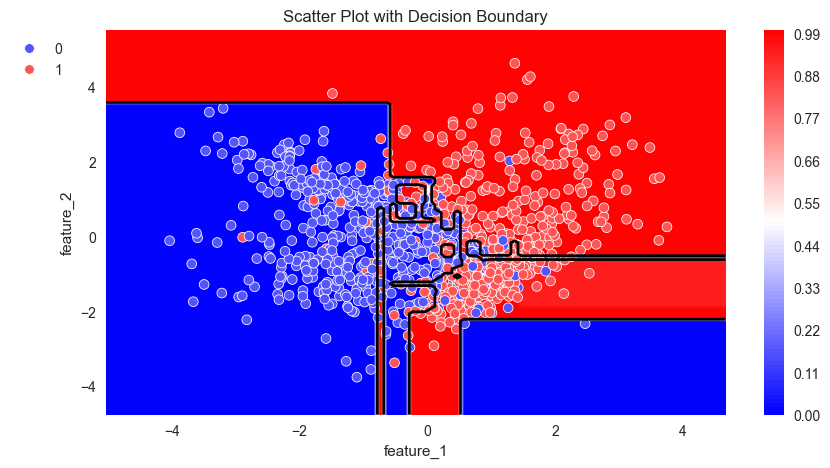

In [19]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
    
plot_probabilities_2d(X, y, model_tr)

In [20]:
print(f'Current depth: {model_bad.get_depth()}')

Current depth: 29


In [22]:
X = water_df.drop('Potability', axis=1)
y = water_df['Potability']

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [30]:
for max_depth in np.arange(5,15):
    model_better = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=max_depth,
        random_state=42,
        class_weight='balanced'
    )

    skf = model_selection.StratifiedKFold(n_splits=5)

    cv_metrics = model_selection.cross_validate(
        estimator=model_better,
        X = X,
        y= y,
        cv = skf,
        scoring='f1',
        return_train_score=True
    )

    print(f'Train K-Fold F1-score mean = {np.mean(cv_metrics['train_score']):.2f}')
    print(f'Valid K-Mean F1-scrore mean = {np.mean(cv_metrics['test_score']):.2f}\n')


Train K-Fold F1-score mean = 0.48
Valid K-Mean F1-scrore mean = 0.40

Train K-Fold F1-score mean = 0.50
Valid K-Mean F1-scrore mean = 0.38

Train K-Fold F1-score mean = 0.56
Valid K-Mean F1-scrore mean = 0.43

Train K-Fold F1-score mean = 0.63
Valid K-Mean F1-scrore mean = 0.48

Train K-Fold F1-score mean = 0.65
Valid K-Mean F1-scrore mean = 0.45

Train K-Fold F1-score mean = 0.69
Valid K-Mean F1-scrore mean = 0.47

Train K-Fold F1-score mean = 0.72
Valid K-Mean F1-scrore mean = 0.47

Train K-Fold F1-score mean = 0.75
Valid K-Mean F1-scrore mean = 0.47

Train K-Fold F1-score mean = 0.79
Valid K-Mean F1-scrore mean = 0.46

Train K-Fold F1-score mean = 0.81
Valid K-Mean F1-scrore mean = 0.46



**Задание 4.6**

In [32]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

model_tr_cutted = tree.DecisionTreeClassifier(
    max_depth=3,
    random_state=42
)

model_tr_cutted.fit(X_train, y_train)

y_train_pred_tr = model_tr_cutted.predict(X_train)
y_valid_pred_tr = model_tr_cutted.predict(X_valid)

print(f'Accuracy metric for train data = {metrics.accuracy_score(y_train, y_train_pred_tr):.2f}')
print(f'Accuracy metric for valid data = {metrics.accuracy_score(y_valid, y_valid_pred_tr):.2f}')

Accuracy metric for train data = 0.88
Accuracy metric for valid data = 0.85


C:\Users\nitys\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


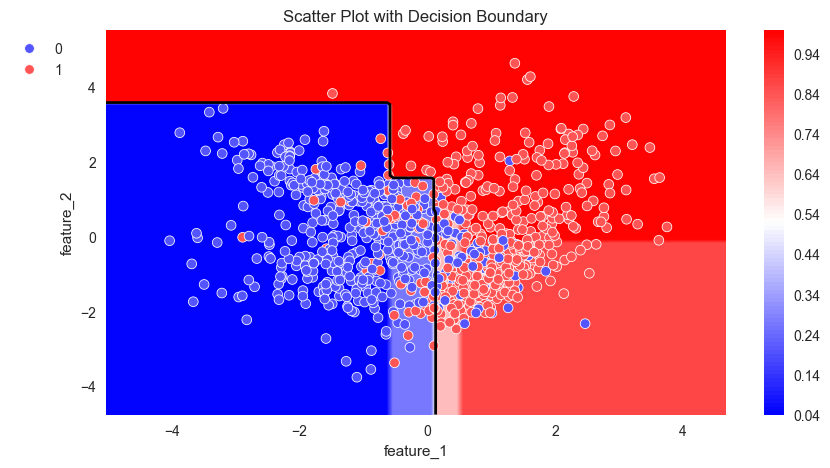

In [33]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
    
plot_probabilities_2d(X, y, model_tr_cutted)

### Кривая обучения

**Построение кривой обучения**

In [34]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

model_curve = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

skf = model_selection.StratifiedKFold(n_splits=5)

train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator=model_curve,
    X = X,
    y = y,
    cv=skf,
    scoring='f1'
)

print(f'Train sizes: {train_sizes}\n')
print(f'train_scores: {train_scores} \n')
print(f'Valid scores: {valid_scores} \n')

Train sizes: [ 80 260 440 620 800]

train_scores: [[0.91489362 0.89473684 0.89473684 0.89473684 0.89473684]
 [0.89962825 0.91385768 0.91512915 0.91512915 0.91512915]
 [0.90153173 0.89519651 0.91938998 0.91416309 0.91416309]
 [0.90542636 0.90734824 0.92209857 0.90909091 0.9057187 ]
 [0.90794451 0.90012642 0.90813648 0.9041769  0.9081761 ]] 

Valid scores: [[0.78448276 0.77714286 0.75268817 0.8342246  0.83597884]
 [0.79069767 0.8172043  0.82352941 0.85436893 0.83902439]
 [0.87254902 0.82291667 0.81730769 0.85436893 0.85294118]
 [0.84210526 0.82795699 0.83168317 0.8195122  0.86138614]
 [0.86567164 0.87046632 0.82051282 0.83       0.86294416]] 



In [ ]:
# Считаем средение значения 
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

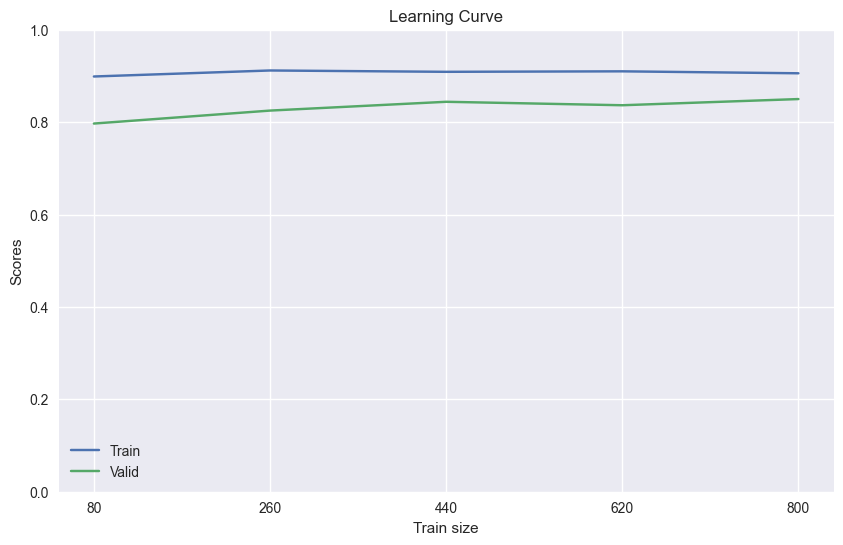

In [38]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(train_sizes, train_scores_mean, label='Train')
ax.plot(train_sizes, valid_scores_mean, label='Valid')

ax.set_title('Learning Curve')
ax.set_xlabel('Train size')
ax.set_ylabel('Scores')

ax.xaxis.set_ticks(train_sizes)

ax.set_ylim(0,1)

ax.legend()



**Построим кривые для несокльких моделей**

In [39]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

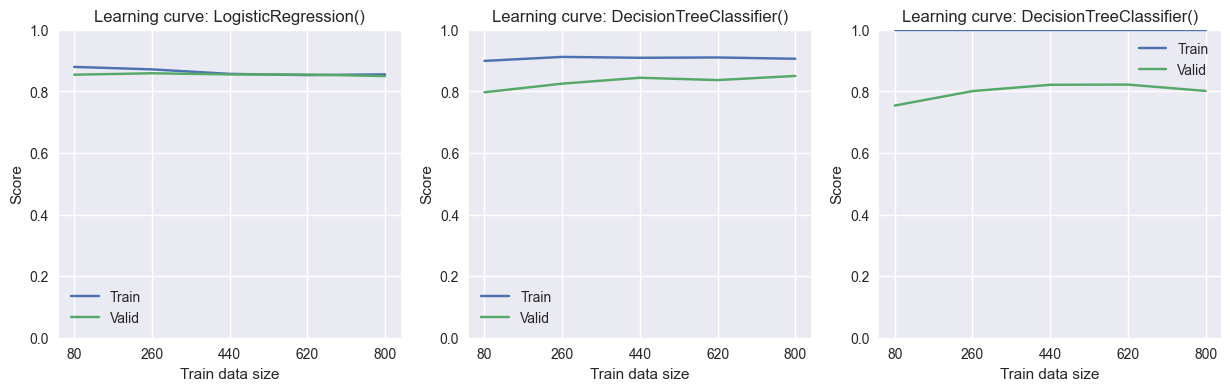

In [40]:


models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

#Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X, y, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)